# Project 5c-SIR models

A classic epidemiological model is called the SIR model, which stands for Susceptible-Infected-Recovered (or more broadly Removed, if the disease is potentially fatal).  As the name implies, this is a population model with three populations.  The equations are pretty simple (even simpler than zombies):
$$
\frac{\partial S}{\partial t} = -\beta S I
$$
$$
\frac{\partial I}{\partial t} = \beta S I - \gamma I
$$
$$
\frac{\partial R}{\partial t} = \gamma I,
$$
yet they have rather successfully been used to model a broad array of epidemics, including, in a practical sense, COVID-19.  Implement the above equations and explore their behavior for a few combinations of parameters and initial conditions.  What are the stable states?  Does this model exhibit periodicity?

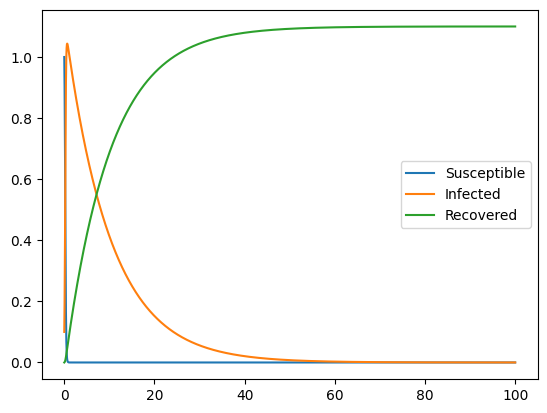

In [1]:
import numpy as np
import ode_methods as om
import matplotlib.pyplot as plt

class SIR:
    
    def __init__(self,beta=10,gamma=0.1):
        
        self.beta = beta    # Infection rate
        self.gamma = gamma  # Recovery/death rate
        self.n_dof = 3      
        
    def rhs(self,t,u):
        # 0 - S
        # 1 - I
        # 2 - R
        
        # the right hand side of the ode (or $\mathcal{F}(t,u)$)
        dudt = np.array([-self.beta*u[0]*u[1],
                         self.beta*u[0]*u[1] - self.gamma*u[1],
                         self.gamma*u[1]])  

        return dudt
    
method = om.Midpoint()

u0 = np.array([1,0.1,0])

s = SIR()
integrator = om.Integrator(s,method)
t,u = integrator.integrate([0,100],0.01,u0)

plt.plot(t,u[:,0],label='Susceptible')
plt.plot(t,u[:,1],label='Infected')
plt.plot(t,u[:,2],label='Recovered')
plt.legend()

This model does not have periodicity. And there does not seem to be a state where it is stable.

### Comparison to observations

While it is useful to examine the qualitative evolution of these systems, they are not necessarily useful for modelling real epidemics because it is not clear *a priori* what the values of the parameters ought to be.  In order to do that, they need to be tuned so as to reproduce a set of real observations.  I have provided for you code to read in and process data from the first year of the pandemic in Montana.

Text(0.5, 0, 'weeks')

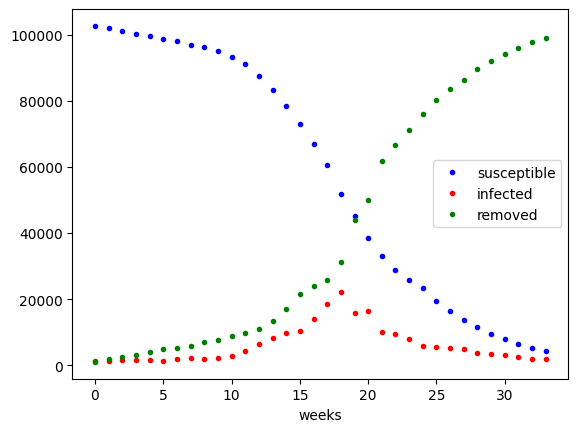

In [2]:
import pandas as pd
data = pd.read_csv('ef7e2f14.csv')

N = 1.05e5 # Initial susceptible population, here taken to be approximately 
          # 1/10 of the actual population of the state
          # or around the same amount of people that end up 
          # getting infected
removed = data['recovered'] + data['deaths']
infected = data['confirmed'] - removed
susceptible = N - infected - removed

removed = removed[removed.notnull()].to_numpy()[100::7]
infected = infected[infected.notnull()].to_numpy()[100::7]
susceptible = susceptible[susceptible.notnull()].to_numpy()[100::7]
times = np.linspace(0,len(susceptible)-1,len(susceptible))


plt.plot(times,susceptible,'b.',label='susceptible')
plt.plot(times,infected,'r.',label='infected')
plt.plot(times,removed,'g.',label='removed')
plt.legend()
plt.xlabel('weeks')

**"fit" the data, which is to say: come up with values for $\gamma$, $\beta$, and $I_0$ such that predictions from the model agree reasonably well with the observations.**

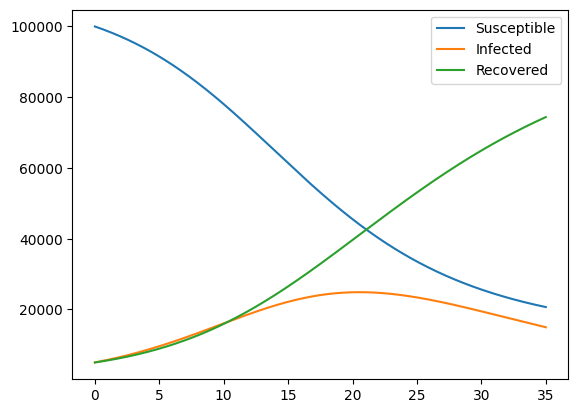

In [3]:
method = om.Midpoint()

u0 = np.array([100000,5000,5000])

s = SIR(beta=0.0000025, gamma=0.11)
integrator = om.Integrator(s,method)
t,u = integrator.integrate([0,35],0.01,u0)

plt.plot(t,u[:,0],label='Susceptible')
plt.plot(t,u[:,1],label='Infected')
plt.plot(t,u[:,2],label='Recovered')
plt.legend()

## Markov Chain Monte Carlo sampling (a more than brief aside)
Tuning models by hand is a tricky task, especially as the number of parameters gets large.  It's also quite subjective, and might not capture all of the possible configurations of the model that could fit the data equivalently well.  As such, we'd like to come up with an automated procedure for fitting models to data.  

This is of course, a rather vast subject.  Indeed, fitting (very flexible) models (with lots of parameters) to data is most of the content of a machine learning class.  In that context, the common practice is to define a cost function (commonly mean squared error) and minimize it using an algorithm called gradient descent.  Such an approach is possible here as well, but requires the efficient differentiation of the ordinary differential equation that we're solving itself using something called [the adjoint method](https://en.wikipedia.org/wiki/Adjoint_state_method).  This is a very interesting topic, but is a bit outside of the scope of our course.

Another downside to gradient descent is that it provides only a single set of optimal model parameters.  However, for real scientific applications, it's typically very useful for us to know something about the *distribution* of possible values that the parameters could take.  For that reason, we'll try to characterize our parameters as probability distributions.  To characterize them, we'll use a tool called the Metropolis-Hastings algorithm. 

### A small example from ballistics
Let's go back to a very simple ballistics problem, namely two dimensional motion without drag.  Recall that the equations were
$$
\frac{\partial \mathbf{x}}{\partial t} = \mathbf{v}
$$
$$
\frac{\partial \mathbf{v}}{\partial t} = \mathbf{g}
$$
where $\mathbf{x}$ is the position vector, $\mathbf{v}$ the velocity vector, $\mathbf{g}=[0,-9.81]^T$ the gravity vector.  The analytical solution to this is 
$$
\mathbf{x}(t) = \mathbf{x}_0 + \mathbf{v}_0 t + \frac{1}{2}\mathbf{g} t^2
$$
Let's say I *do* know the location from which the projectile was launched, but that I *don't* know its initial velocity.  This latter quantity I would like to infer.  I do have a noisy measurement of its position at some point in time.  As an example, lets say at $t = 1.0$s, I measure its position to be $\mathbf{x}(1s) = [10,3]$m.  What can I say about its initial position and velocity?  

Bayes' theorem gives us an answer:
$$
P(\mathbf{v}_0|\hat{\mathbf{x}}_1) = \frac{P(\hat{\mathbf{x}}_1|\mathbf{v}_0) P(\mathbf{v_0})}{P(\hat{\mathbf{x}}_1)},
$$
where I've used a hat to indicate an observed quantity.  

The term on the left hand side is what we want: the probability distribution of the initial position and velocity given the observed position at some time.  The right hand side includes things that we can make assumptions about.  $P(\mathbf{v}_0)$ is a *prior* distribution, which encodes the distribution of possible initial velocities before looking at any data.  Let's assume that this is proportional to 1, which is equivalent to saying that I don't know anything about the velocity to start with.  

The other term $P(\mathbf{x}_1|\mathbf{v}_0)$ is called a *likelihood*, and it asks the question "what is the probability of making the observation ($\hat{\mathbf{x}}_1$) for some given value of $\mathbf{v}_0$.  Answering this question has two parts here: first, I need to map from $\mathbf{v}_0$ to a hypothesized position at $t=1$s.  This is is easy to do with our model.  Define
$$
\mathbf{x}_1(\mathbf{v}_0) \equiv \mathbf{x}_0 + \mathbf{v}_0 (1) + \frac{1}{2} \mathbf{g} (1)^2.
$$
Second, we need to make an assumption about uncertainty in our measurement.  A common and sometimes justified approach is to say that the observation is *normally* distributed around the true value, i.e.
$$
\hat{\mathbf{x}}_1 = \mathbf{x}_1 + \boldsymbol{\epsilon }
$$
$$
\boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0},\Sigma)
$$
$$
\Sigma = \begin{bmatrix} \sigma^2_{obs} & 0 \\ 0 & \sigma^2_{obs} \end{bmatrix}
$$
More concisely, we can write
$$
P(\hat{\mathbf{x}}_1 | \mathbf{v}_0) = \mathcal{N}(\mathbf{x}_1(\mathbf{v}_0), \Sigma).
$$

Finally, we have the denominator term
$$
P(\hat{\mathbf{x}}_1) = \int P(\hat{\mathbf{x}_1}|\mathbf{v}_0) P (\mathbf{v}_0) \; \mathrm{d}\mathbf{v}_0,
$$
which is sometimes called the *evidence*.  This is quite pesky to evaluate because that integral is over all possible values of $\mathbf{v}_0$.  In fact, for most non-trivial models, it's impossible to compute exactly, and it is from this intractibility that most of the richness of Bayesian statistics emerges.

One idea (which is popular in machine learning) is to simply *maximize* $P(\mathbf{v}_0 | \hat{\mathbf{x}}_1)$.  Because $\hat{\mathbf{x}}_1$ does not depend upon the velocity, it's a constant and we can ignore it.  However, this does not yield any notion of uncertainty.  Another relatively simple idea is to perform a brute force Monte Carlo integration: randomly sample a large number of $\mathbf{v}_0$, and compute the integral as 
$$
\int P(\hat{\mathbf{x}_1}|\mathbf{v}_0) P (\mathbf{v}_0) \; \mathrm{d}\mathbf{v}_0 \approx \frac{1}{N} \sum_{j=1}^N P(\hat{\mathbf{x}_1}|\mathbf{v}_{0,j}) 
$$
with 
$\mathbf{v}_{0,j}$ a sample drawn from a prior distribution over $\mathbf{v}$.  Of course, we said that this was just going to be proportional to 1, which means that any pair of real numbers is equally likely, and this just won't work.  Instead, let's put a simple bound and say that our initial velocities are between 0 and 20.  

It is easiest to see how this works in code.  First, let's make a function that evaluates the posterior up to a multiplicative constant (or rather its logarithm).

In [4]:
class ProjectilePosterior:
    def __init__(self,x_0,g,x_obs,t_obs,sigma2_obs):
        self.x_0 = x_0
        self.g = g
        self.x_obs = x_obs
        self.t_obs = t_obs
        self.sigma2_obs = sigma2_obs
        
    def log_posterior(self,v_0):
        # This is the forward model
        x_pred = self.x_0 + v_0*self.t_obs[:,np.newaxis] + 0.5*self.g*self.t_obs[:,np.newaxis]**2
        
        # This is the log-likelihood
        P = -(0.5*(x_pred - self.x_obs)**2/self.sigma2_obs 
             + 0.5*np.log(self.sigma2_obs) 
             + 0.5*(np.log(2*np.pi))).sum()
        return P

In [5]:
# Observations
x_obs = np.array([10,3])
t_obs = np.array([1.])

# Observational uncertainty
sigma2_obs = 0.1

# Initial conditions
x_0 = np.array([0.,0.])

g = np.array([0,-9.81])

proj_like = ProjectilePosterior(x_0,g,x_obs,t_obs,sigma2_obs)

v_0 = np.array([-10.,1.])
print(proj_like.log_posterior(v_0))


-2237.9304169734155


Let's draw some samples of possible values of $v_0$ and evaluate them.

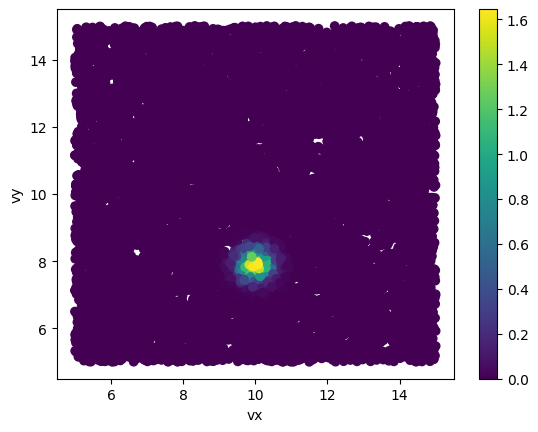

In [6]:
v_samples = np.random.rand(10000,2)*10 + 5
log_posteriors = np.array([proj_like.log_posterior(v) for v in v_samples])
posteriors = np.exp(log_posteriors)
mean_posteriors = posteriors.mean()
posteriors/=mean_posteriors

V = 100
posteriors/=V

plt.scatter(*v_samples.T,c=posteriors)
plt.xlabel('vx')
plt.ylabel('vy')
plt.colorbar()

We can plot trajectories for each of these samples, with the alpha channel set to be proportional to the probabilities

Text(0, 0.5, 'y')

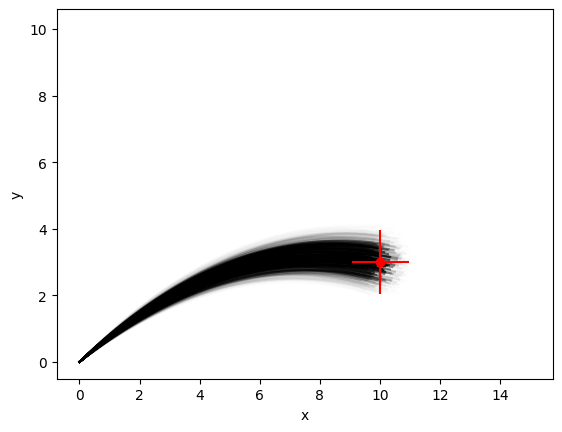

In [7]:
t = np.linspace(0,1,101)
for i in range(10000):
    sol = x_0 + np.outer(t,v_samples[i]) + 0.5*np.outer(t**2,g)
    plt.plot(sol[:,0],sol[:,1],'k-',alpha=posteriors[i]/posteriors.max())
plt.errorbar([x_obs[0]],[x_obs[1]],xerr=3*np.sqrt(sigma2_obs),yerr=3*np.sqrt(sigma2_obs),fmt='ro')
plt.xlabel('x')
plt.ylabel('y')

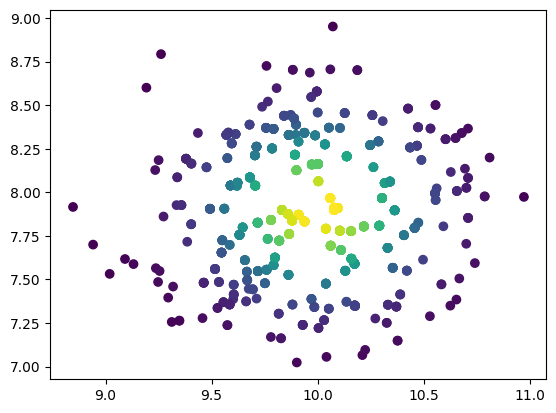

In [8]:
# Importance sampling - draw from computed samples proportionally to their log posterior
random_indices = np.random.choice(len(v_samples),p=posteriors/posteriors.sum(),size=1000)
sub_samples = v_samples[random_indices]
sub_posteriors = posteriors[random_indices]
plt.scatter(*sub_samples.T,c=sub_posteriors)


(array([  9.,  73., 117., 168., 263., 132., 177.,  45.,  14.,   2.]),
 array([7.02341756, 7.21626741, 7.40911726, 7.6019671 , 7.79481695,
        7.9876668 , 8.18051665, 8.3733665 , 8.56621635, 8.7590662 ,
        8.95191605]),
 <BarContainer object of 10 artists>)

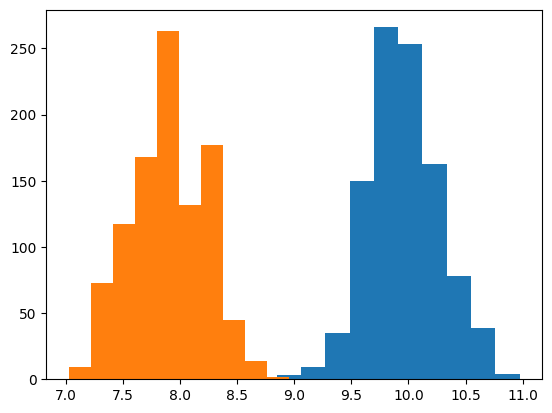

In [9]:
plt.hist(sub_samples[:,0])
plt.hist(sub_samples[:,1])

This works really well!  Except that we start to run into a problem as the dimensionality of the system increases.  With 10000 points in 2D space, we have around 100 samples per side.  If we were working in 3D space (let's say that we also didn't know one component of the initial position) and had the same number of total random points: now we'd only have $N=10000^{\frac{2}{3}}$ points for some cross section.  This sampling density would look like this:

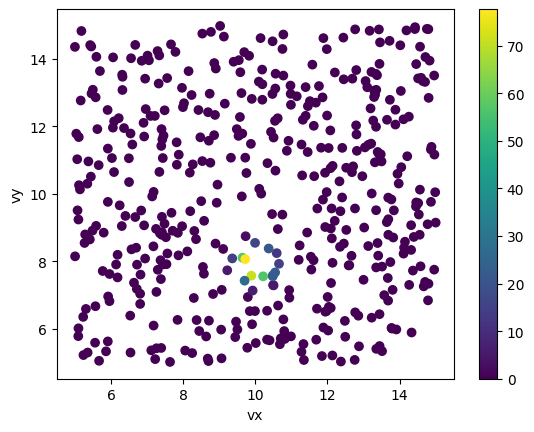

In [10]:
v_samples = np.random.rand(int(10000**(2./3.)),2)*10 + 5
log_posteriors = np.array([proj_like.log_posterior(v) for v in v_samples])
posteriors = np.exp(log_posteriors)
mean_posteriors = posteriors.mean()
posteriors/=mean_posteriors

plt.scatter(*v_samples.T,c=posteriors)
plt.xlabel('vx')
plt.ylabel('vy')
plt.colorbar()

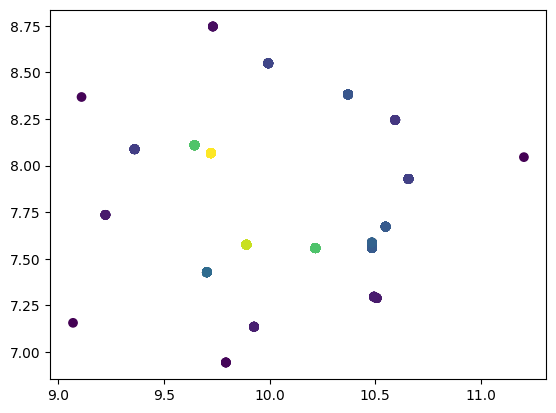

In [11]:
random_indices = np.random.choice(len(v_samples),p=posteriors/posteriors.sum(),size=1000)
sub_samples = v_samples[random_indices]
sub_posteriors = posteriors[random_indices]
plt.scatter(*sub_samples.T,c=sub_posteriors)

This becomes problematic quickly.  An alternative method that doesn't have all the same shortcomings is to use the Metropolis algorithm, which is a type of Markov Chain Monte Carlo (MCMC) method (Monte Carlo because it's random, Markov Chain because we create new samples by making a small perturbation to an existing sample).  The algorithm is quite simple.  We begin with some random value for $\mathbf{v}_0$.  Next, we make a small modification according to a so-called proposal distribution $
q(\mathbf{v}_{0,i+1} | \mathbf{v}_{0,i}) = \mathcal{N}(\mathbf{v}_{0,i} | h^2),
$
where $h$ is a (usually pretty small) step size.  We then evaluate the posterior for the new location and for the current location.  If
$
\frac{P(\mathbf{v}_{0,i+1}|\mathbf{x}_1)}{P(\mathbf{v}_{0,i|\mathbf{x}_1})} \ge 1,
$
then we accept the proposed value of $\mathbf{v}_0$.  If 
$
\frac{P(\mathbf{v}_{0,i+1}|\mathbf{x}_1)}{P(\mathbf{v}_{0,i}|\mathbf{x}_1)} < 1,
$
then we accept with probability given by this ratio.  We then repeat this process many times, saving the result of the sampling at each step in the algorithm.  It turns out that the values stored in the chain are samples from the posterior distribution.  Let's see how this works.  

In [12]:
# Initial guess
v_0 = np.array([1.,1.])

# Initial unscaled log-probability 
P_0 = proj_like.log_posterior(v_0)

# Initialize the Markov Chain
P_chain = [P_0]
v_chain = [v_0]

# Stepsize
h = 0.1

# Draw 10000 samples
for i in range(10000):

    # Propose a new sample
    v_prime = v_0 + np.random.randn(2)*h
    
    # Compute the unscaled log-probability at that location
    P_1 = proj_like.log_posterior(v_prime)
    
    # Compute the logarithm of the ratios
    log_ratio = P_1 - P_0
    
    # Convert back to non-log space
    ratio = np.exp(log_ratio)
    
    # If the new location is more probable than the old one,
    # accept the proposal.  If it's not, accept the proposal
    # with probability given by the ratio
    if ratio>np.random.rand():
        v_0 = v_prime
        P_0 = P_1
        
    # Append to the chain (regardless of whether we accepted)
    P_chain.append(P_0)
    v_chain.append(v_0)

# Convert lists to numpy arrays
# burnin helps to remove first set of values to get a better prediction
burnin = 0
P_chain = np.array(P_chain[burnin:])
v_chain = np.array(v_chain[burnin:])

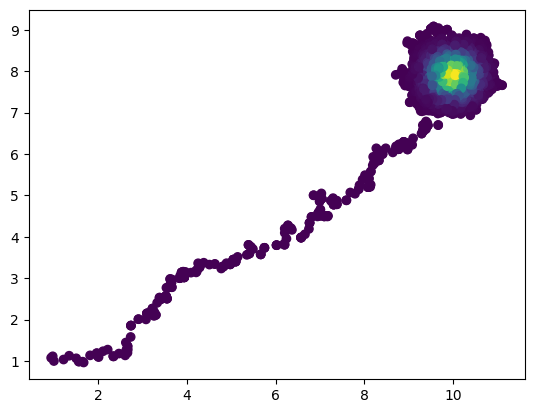

In [13]:
plt.scatter(*v_chain.T,c=np.exp(P_chain))

(array([  11.,   68.,  400., 1167., 2351., 2547., 1686.,  634.,  107.,
          30.]),
 array([ 8.71112803,  8.95093929,  9.19075055,  9.43056182,  9.67037308,
         9.91018435, 10.14999561, 10.38980687, 10.62961814, 10.8694294 ,
        11.10924066]),
 <BarContainer object of 10 artists>)

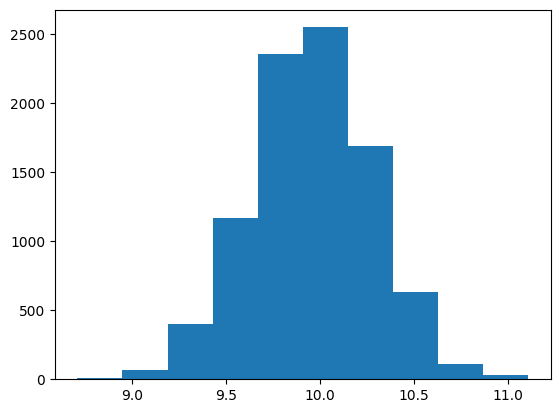

In [14]:
plt.hist(v_chain[1000:,0])

Text(0, 0.5, 'y')

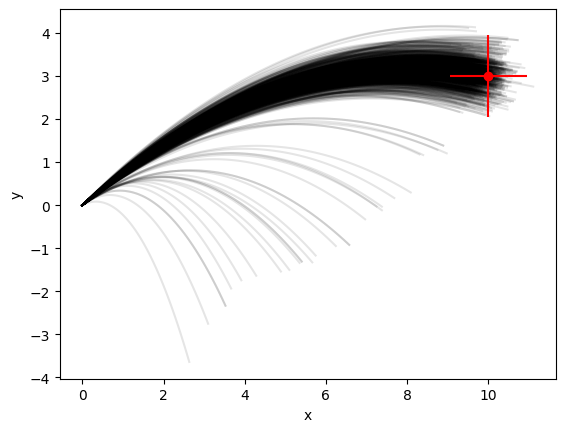

In [15]:
# Compute some sample trajectories from the distribution of initial conditions
t = np.linspace(0,1,101)
for i in range(1000):
    i = np.random.randint(v_chain.shape[0])
    sol = x_0 + np.outer(t,v_chain[i]) + 0.5*np.outer(t**2,g)
    plt.plot(sol[:,0],sol[:,1],'k-',alpha=0.1)
plt.errorbar([x_obs[0]],[x_obs[1]],xerr=3*np.sqrt(sigma2_obs),yerr=3*np.sqrt(sigma2_obs),fmt='ro')
plt.xlabel('x')
plt.ylabel('y')

As is usually the case, it is a good idea to use an object-oriented model so that we can avoid having to rewrite code.  We can easily write a Metropolis algorithm class that works with a general parameter vector $\mathbf{m}$.

In [16]:
class Metropolis:
    def __init__(self):
        # Initialize chains
        self.P_chain = []
        self.m_chain = []
        
    def sample(self,m_0,log_posterior,h,n_samples,burnin=0,thin_factor=1):
        # Compute initial unscaled log-posterior
        P_0 = log_posterior(m_0)
        
        # Add initial location and posterior to the chain
        self.P_chain.append(P_0)
        self.m_chain.append(m_0)
        n = len(m_0)

        # Draw samples
        for i in range(n_samples):

            # Propose new value
            m_prime = m_0 + np.random.randn(n)*h

            # Compute new unscaled log-posterior
            P_1 = log_posterior(m_prime)
            
            # Compute logarithm of probability ratio
            log_ratio = P_1 - P_0
            
            # Convert to non-log space
            ratio = np.exp(log_ratio)
            
            # If proposed value is more probable than current value, accept.  
            # If not, then accept proportional to the probability ratios
            if ratio>np.random.rand():
                m_0 = m_prime
                P_0 = P_1
                
            # Only append to the chain if we're past burn-in. 
            if i>burnin:
                # Only append every j-th sample to the chain
                if i%thin_factor==0:
                    self.P_chain.append(P_0)
                    self.m_chain.append(m_0)
                    
        return np.array(self.P_chain),np.array(self.m_chain)

# Instantiate sampler
sampler = Metropolis()

# Draw samples
P_chain,m_chain = sampler.sample(v_0,proj_like.log_posterior,0.1,10000,burnin=1000)

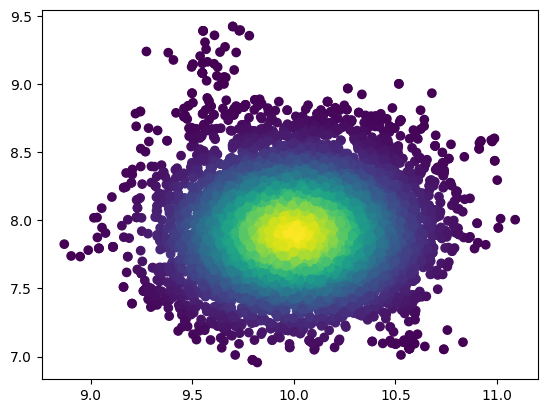

In [17]:
plt.scatter(*m_chain.T,c=np.exp(P_chain))

Of course we could do the same thing but with more unknowns.  For example, we could assume that *both* initial velocity and initial position are unknown.  However, before we start, **we should ask whether this problem is well posed.**  

In [18]:
class ProjectilePosteriorWithX:
    def __init__(self,g,x_obs,t_obs,sigma2_obs):
        self.g = g
        self.x_obs = x_obs
        self.t_obs = t_obs
        self.sigma2_obs = sigma2_obs
        
    def log_posterior(self,m_0):
        x_0 = m_0[:2]
        v_0 = m_0[2:]
        x_pred = x_0 + v_0*self.t_obs[:,np.newaxis] + 0.5*self.g*self.t_obs[:,np.newaxis]**2
        P = -(0.5*(x_pred - x_obs)**2/sigma2_obs 
             + 0.5*np.log(sigma2_obs) 
             + 0.5*(np.log(2*np.pi))).sum()
        return P

In [19]:
proj_like = ProjectilePosteriorWithX(g,x_obs,t_obs,sigma2_obs)

v_0 = np.array([1.,1.])
x_0 = np.array([0,0])

# Concatenate intial position *and* velocity into parameter vector
m_0 = np.hstack((x_0,v_0))

sampler = Metropolis()
P_chain,m_chain = sampler.sample(m_0,proj_like.log_posterior,0.1,100000,burnin=1000)

Text(0, 0.5, 'y')

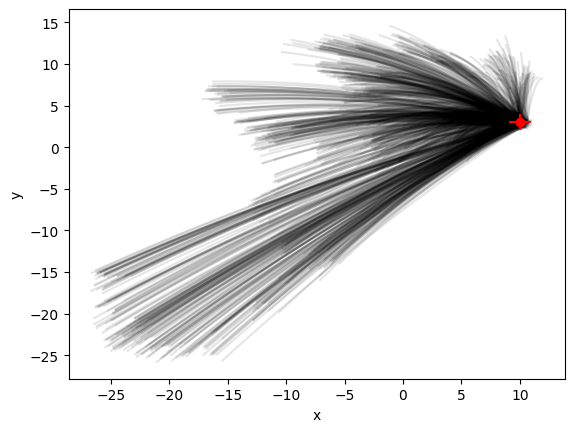

In [20]:
t = np.linspace(0,1,101)
for i in range(1000):
    i = np.random.randint(m_chain.shape[0])
    x = m_chain[i,:2]
    v = m_chain[i,2:]
    sol = x + np.outer(t,v) + 0.5*np.outer(t**2,g)
    plt.plot(sol[:,0],sol[:,1],'k-',alpha=0.1)
plt.errorbar([x_obs[0]],[x_obs[1]],xerr=3*np.sqrt(sigma2_obs),yerr=3*np.sqrt(sigma2_obs),fmt='ro')
plt.xlabel('x')
plt.ylabel('y')

Lots of possible solutions are consistent with this data!  What if we change up the situation and say that we add a second observation, namely that $\hat{\mathbf{x}}_{t=1/2} = \begin{bmatrix} 5 \\ 2 \end{bmatrix} $

In [21]:
x_obs = np.array([[5,2],[10,3]])
t_obs = np.array([0.5,1.])
sigma2_obs = 0.1

proj_like = ProjectilePosteriorWithX(g,x_obs,t_obs,sigma2_obs)

v_0 = np.array([1.,1.])
x_0 = np.array([0,0])
m_0 = np.hstack((x_0,v_0))

sampler = Metropolis()
P_chain,m_chain = sampler.sample(m_0,proj_like.log_posterior,0.1,10000,burnin=1000)

Text(0, 0.5, 'y')

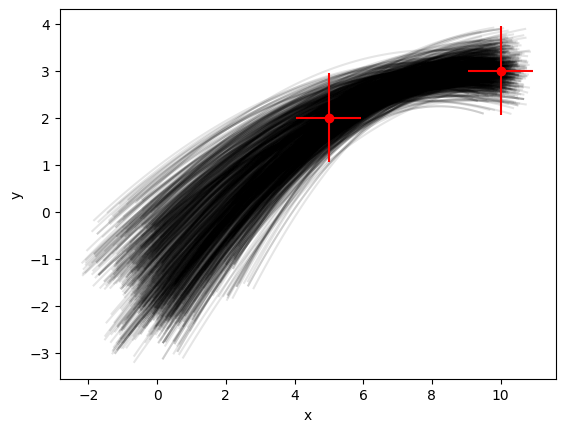

In [22]:
t = np.linspace(0,1,101)
for i in range(1000):
    i = np.random.randint(m_chain.shape[0])
    x = m_chain[i,:2]
    v = m_chain[i,2:]
    sol = x + np.outer(t,v) + 0.5*np.outer(t**2,g)
    plt.plot(sol[:,0],sol[:,1],'k-',alpha=0.1)
plt.errorbar(x_obs[:,0],x_obs[:,1],xerr=3*np.sqrt(sigma2_obs),yerr=3*np.sqrt(sigma2_obs),fmt='ro')
plt.xlabel('x')
plt.ylabel('y')

### MCMC for SIR modelling
We can proceed with using the Metropolis algorithm to find the initial conditions *and* parameters of an SIR model in much the same way as above.  The only difference is in the number of parameters (here we'll have 5) and how we compute the proportional log-posterior (it will involve the solution of our ODE!).  



In [23]:
class SIRPosterior:
    def __init__(self,t_obs,u_obs,sigma2_obs):
        self.u_obs = u_obs
        self.t_obs = t_obs
        self.sigma2_obs = sigma2_obs
        
    def log_posterior(self,log_m):
        # We have defined our parameters to sample over as the logarithm
        # of the model parameters.  Here we exponentiate them to get
        # the representation that we need.  
        m = np.exp(log_m)
        S_0 = m[0]
        I_0 = m[1]
        R_0 = m[2]
        beta = m[3]
        gamma = m[4]
        
        u0 = np.array([S_0,I_0,R_0])

        s = SIR(beta=beta,gamma=gamma)
        integrator = om.Integrator(s,method)
        t,u = integrator.integrate([times[0],times[-1]],1,u0)
        P = -0.5*np.sum((self.u_obs - u)**2)/self.sigma2_obs
        return P

In [24]:
S_obs = susceptible/N
I_obs = infected/N
R_obs = removed/N

u_obs = np.c_[S_obs,I_obs,R_obs]

sigma2_obs = 0.01

sir_like = SIRPosterior(t_obs,u_obs,sigma2_obs)

m_0 = np.log(np.array([1.0,0.01,0.1,3.0,1.0]))

sampler = Metropolis()
P_chain,m_chain = sampler.sample(m_0,sir_like.log_posterior,0.1,10000,burnin=1000)

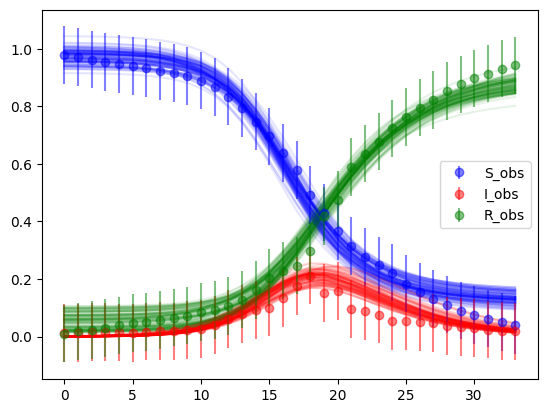

In [25]:
for i in range(100):
    j = np.random.randint(len(m_chain))
    m_best = np.exp(m_chain[j])
    S_0 = m_best[0]
    I_0 = m_best[1]
    R_0 = m_best[2]
    beta = m_best[3]
    gamma = m_best[4]

    u0 = np.array([S_0,I_0,R_0])
    s = SIR(beta=beta,gamma=gamma)
    integrator = om.Integrator(s,method)
    t,u = integrator.integrate([times[0],times[-1]],1,u0)

    plt.plot(t,u[:,0],'b-',alpha=0.1)
    plt.plot(t,u[:,1],'r-',alpha=0.1)
    plt.plot(t,u[:,2],'g-',alpha=0.1)
plt.errorbar(times,S_obs,yerr=np.sqrt(sigma2_obs),fmt='bo',label='S_obs',alpha=0.5)
plt.errorbar(times,I_obs,yerr=np.sqrt(sigma2_obs),fmt='ro',label='I_obs',alpha=0.5)
plt.errorbar(times,R_obs,yerr=np.sqrt(sigma2_obs),fmt='go',label='R_obs',alpha=0.5)
plt.legend()

Pretty good fit (although there are details that the model is missing).  One critical piece of information that epidemiologists care about is the basic reproduction number, called $R_0$ which is, roughly speaking, the number of other people that a single infected person is likely to infect.  This number has a direct link to SIR models, because it can be computed as the ratio of $\beta$ and $\gamma$.  We can do one better than estimation: we can estimate the distribution of $R_0$ that is consistent with observations.  Let's produce a simple histogram:

(array([6.15268445e-01, 1.51350845e+00, 2.34814476e+00, 3.47354084e+00,
        1.95094614e+00, 7.11323012e-01, 2.92057806e-01, 5.29598155e-01,
        2.46626592e-01, 1.29803469e-03]),
 array([2.14400507, 2.22960457, 2.31520406, 2.40080355, 2.48640304,
        2.57200254, 2.65760203, 2.74320152, 2.82880101, 2.91440051,
        3.        ]),
 <BarContainer object of 10 artists>)

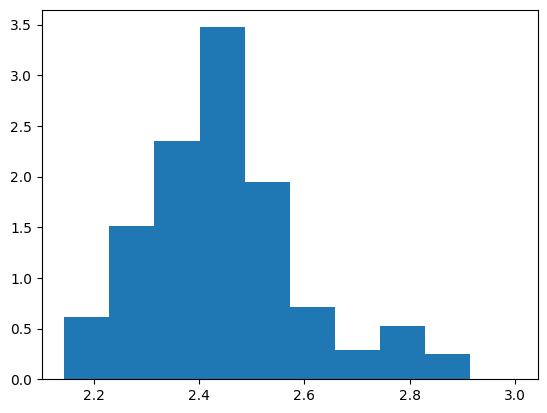

In [26]:
plt.hist(np.exp(m_chain)[:,3]/np.exp(m_chain)[:,4],density=True)

It would appear that our estimated $R_0$ is between 2 and 2.7.  This is in strong agreement with the independently estimated COVID-19 values!

### SEIR Model
We can make a simple modification to the SIR model that can sometimes help fit diseases for which there is a significant non-infectious incubation period.  Such a model introduces an additional population (called Exposed), and the resulting model is 
$$
\frac{\partial S}{\partial t} = -\beta S I
$$
$$
\frac{\partial E}{\partial t} = \beta S I - a E
$$
$$
\frac{\partial I}{\partial t} = a E - \gamma I
$$
$$
\frac{\partial R}{\partial t} = \gamma I.
$$
**Adapt both the simulation machinery and the model fitting procedure above to work with this SEIR model.  Does such a model yield a better fit to the observations than the SIR model?**

In [27]:
class SEIR:
    
    def __init__(self,beta=10,gamma=0.1, alpha=0.1):
        
        self.beta = beta    # Infection rate
        self.gamma = gamma  # Recovery/death rate
        self.alpha = alpha
        self.n_dof = 3
        
    def rhs(self,t,u):
        # 0 - S
        # 1 - E
        # 2 - I
        # 3 - R
        
        # the right hand side of the ode (or $\mathcal{F}(t,u)$)
        dudt = np.array([-self.beta*u[0]*u[2], 
            self.beta*u[0]*u[2] - self.alpha*u[1],
            self.alpha*u[1]-self.gamma*u[2],
            self.gamma*u[2]])  

        return dudt

In [28]:
class SEIRPosterior:
    def __init__(self,t_obs,u_obs,sigma2_obs):
        self.u_obs = u_obs
        self.t_obs = t_obs
        self.sigma2_obs = sigma2_obs
        
    def log_posterior(self,log_m):
        # We have defined our parameters to sample over as the logarithm
        # of the model parameters.  Here we exponentiate them to get
        # the representation that we need.  
        m = np.exp(log_m)
        S_0 = m[0]
        E_0 = m[1]
        I_0 = m[2]
        R_0 = m[3]
        beta = m[4]
        gamma = m[5]
        alpha = m[6]
        
        u0 = np.array([S_0,E_0,I_0,R_0])

        s = SEIR(beta=beta,gamma=gamma,alpha=alpha)
        integrator = om.Integrator(s,method)
        t,u = integrator.integrate([times[0],times[-1]],1,u0)
        u_test = np.array([u[:,0], u[:,2], u[:,3]]).T
        P = -0.5*np.sum((self.u_obs - u_test)**2)/self.sigma2_obs
        return P

In [29]:
S_obs = susceptible/N
I_obs = infected/N
R_obs = removed/N

u_obs = np.c_[S_obs,I_obs,R_obs]

sigma2_obs = 0.01

sir_like = SEIRPosterior(t_obs,u_obs,sigma2_obs)

S = 1.0
E = 0.1
I = 0.01
R = 0.1
beta = 3.0
gamma = 1.0
alpha = 1.0

m_0 = np.log(np.array([S, E, I, R, beta, gamma, alpha]))

sampler = Metropolis()
P_chain,m_chain = sampler.sample(m_0,sir_like.log_posterior,0.1,10000,burnin=1000)

C:\Users\jayce\AppData\Local\Temp\ipykernel_4272\2640855033.py:17: RuntimeWarning: overflow encountered in scalar multiply
  dudt = np.array([-self.beta*u[0]*u[2],
C:\Users\jayce\AppData\Local\Temp\ipykernel_4272\2640855033.py:18: RuntimeWarning: overflow encountered in scalar multiply
  self.beta*u[0]*u[2] - self.alpha*u[1],
C:\Users\jayce\AppData\Local\Temp\ipykernel_4272\2640855033.py:18: RuntimeWarning: invalid value encountered in scalar subtract
  self.beta*u[0]*u[2] - self.alpha*u[1],
C:\Users\jayce\AppData\Local\Temp\ipykernel_4272\1357239840.py:26: RuntimeWarning: overflow encountered in square
  P = -0.5*np.sum((self.u_obs - u_test)**2)/self.sigma2_obs
c:\Users\jayce\Desktop\Classes\CSCI477\population_dynamics\ode_methods.py:85: RuntimeWarning: invalid value encountered in add
  k2 = ode.rhs(t + dt / 2.0, u_0 + dt / 2.0 * k1)


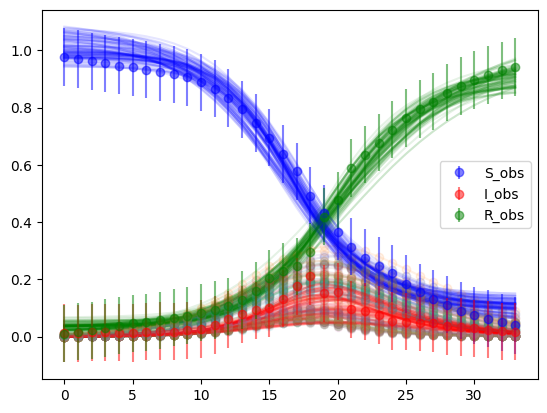

In [30]:
for i in range(100):
    j = np.random.randint(len(m_chain))
    m_best = np.exp(m_chain[j])
    S_0 = m_best[0]
    E_0 = m_best[1]
    I_0 = m_best[2]
    R_0 = m_best[3]
    beta = m_best[4]
    gamma = m_best[5]
    alpha = m_best[6]

    u0 = np.array([S_0,E_0,I_0,R_0])
    s = SEIR(beta=beta,gamma=gamma, alpha=alpha)
    integrator = om.Integrator(s,method)
    t,u = integrator.integrate([times[0],times[-1]],1,u0)

    plt.plot(t,u[:,0],'b-',alpha=0.1)
    plt.plot(t,u[:,2],'r-',alpha=0.1)
    plt.plot(t,u[:,3],'g-',alpha=0.1)
    plt.plot(t, u[:,1], 'o-', alpha=0.1)
plt.errorbar(times,S_obs,yerr=np.sqrt(sigma2_obs),fmt='bo',label='S_obs',alpha=0.5)
plt.errorbar(times,I_obs,yerr=np.sqrt(sigma2_obs),fmt='ro',label='I_obs',alpha=0.5)
plt.errorbar(times,R_obs,yerr=np.sqrt(sigma2_obs),fmt='go',label='R_obs',alpha=0.5)
plt.legend()

This model does not seem to have a better fit. It seems to just add another parameter that does not improve the previous findings.

### SEIRS Model
Another interesting model that perhaps does a better job of modelling the dynamics of COVID-19 is an SEIRS model, in which those in the recovered population eventually become susceptible again (this should be quite straightforward to include in the model).  **Repeat the process above with an SEIRS model.  Does it improve the fit?  Why or why not?  If you run this model far into the future using parameters based on this relatively short calibration window, what sort of epidemiological conclusions can you make and how certain are you in them?**


In [31]:
class SEIRS:
    
    def __init__(self,beta=10,gamma=0.1, alpha=0.1, omega=0.1):
        
        self.beta = beta    # Infection rate
        self.gamma = gamma  # Recovery/death rate
        self.alpha = alpha
        self.omega = omega
        self.n_dof = 3
        
    def rhs(self,t,u):
        # 0 - S
        # 1 - E
        # 2 - I
        # 3 - R
        
        # the right hand side of the ode (or $\mathcal{F}(t,u)$)
        dudt = np.array([-self.beta*u[0]*u[2] + self.omega*u[3], 
            self.beta*u[0]*u[2] - self.alpha*u[1],
            self.alpha*u[1]-self.gamma*u[2],
            self.gamma*u[2]] - self.omega*u[3])  

        return dudt

In [32]:
class SEIRSPosterior:
    def __init__(self,t_obs,u_obs,sigma2_obs):
        self.u_obs = u_obs
        self.t_obs = t_obs
        self.sigma2_obs = sigma2_obs
        
    def log_posterior(self,log_m):
        # We have defined our parameters to sample over as the logarithm
        # of the model parameters.  Here we exponentiate them to get
        # the representation that we need.  
        m = np.exp(log_m)
        S_0 = m[0]
        E_0 = m[1]
        I_0 = m[2]
        R_0 = m[3]
        beta = m[4]
        gamma = m[5]
        alpha = m[6]
        omega = m[7]
        
        u0 = np.array([S_0,E_0,I_0,R_0])

        s = SEIRS(beta=beta,gamma=gamma,alpha=alpha, omega=omega)
        integrator = om.Integrator(s,method)
        t,u = integrator.integrate([times[0],times[-1]],1,u0)
        u_test = np.array([u[:,0], u[:,2], u[:,3]]).T
        P = -0.5*np.sum((self.u_obs - u_test)**2)/self.sigma2_obs
        return P

In [33]:
S_obs = susceptible/N
I_obs = infected/N
R_obs = removed/N

u_obs = np.c_[S_obs,I_obs,R_obs]

sigma2_obs = 0.01

sir_like = SEIRSPosterior(t_obs,u_obs,sigma2_obs)

S = 1.0
E = 0.1
I = 0.01
R = 0.1
beta = 3.0
gamma = 1.0
alpha = 1.0
omega = 0.1

m_0 = np.log(np.array([S, E, I, R, beta, gamma, alpha, omega]))

sampler = Metropolis()
P_chain,m_chain = sampler.sample(m_0,sir_like.log_posterior,0.1,10000,burnin=1000)

C:\Users\jayce\AppData\Local\Temp\ipykernel_4272\3624590856.py:18: RuntimeWarning: overflow encountered in scalar multiply
  dudt = np.array([-self.beta*u[0]*u[2] + self.omega*u[3],
C:\Users\jayce\AppData\Local\Temp\ipykernel_4272\3624590856.py:19: RuntimeWarning: overflow encountered in scalar multiply
  self.beta*u[0]*u[2] - self.alpha*u[1],
C:\Users\jayce\AppData\Local\Temp\ipykernel_4272\3624590856.py:19: RuntimeWarning: invalid value encountered in scalar subtract
  self.beta*u[0]*u[2] - self.alpha*u[1],
C:\Users\jayce\AppData\Local\Temp\ipykernel_4272\3444800501.py:27: RuntimeWarning: overflow encountered in square
  P = -0.5*np.sum((self.u_obs - u_test)**2)/self.sigma2_obs
c:\Users\jayce\Desktop\Classes\CSCI477\population_dynamics\ode_methods.py:86: RuntimeWarning: invalid value encountered in add
  u_1 = u_0 + dt * k2


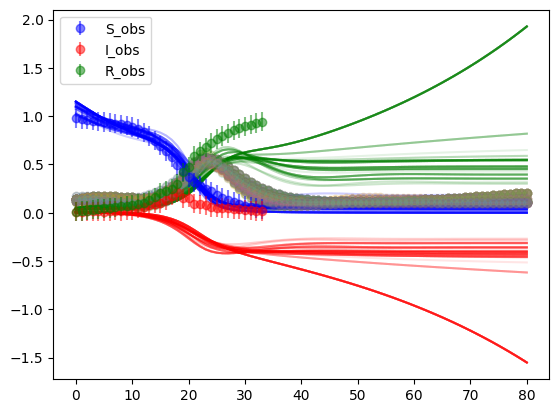

In [36]:
for i in range(100):
    j = np.random.randint(len(m_chain))
    m_best = np.exp(m_chain[j])
    S_0 = m_best[0]
    E_0 = m_best[1]
    I_0 = m_best[2]
    R_0 = m_best[3]
    beta = m_best[4]
    gamma = m_best[5]
    alpha = m_best[6]
    omega = m_best[7]

    u0 = np.array([S_0,E_0,I_0,R_0])
    s = SEIRS(beta=beta,gamma=gamma, alpha=alpha, omega=omega)
    integrator = om.Integrator(s,method)
    t,u = integrator.integrate([times[0],80],1,u0)

    plt.plot(t,u[:,0],'b-',alpha=0.1)
    plt.plot(t,u[:,2],'r-',alpha=0.1)
    plt.plot(t,u[:,3],'g-',alpha=0.1)
    plt.plot(t, u[:,1], 'o-', alpha=0.1)
plt.errorbar(times,S_obs,yerr=np.sqrt(sigma2_obs),fmt='bo',label='S_obs',alpha=0.5)
plt.errorbar(times,I_obs,yerr=np.sqrt(sigma2_obs),fmt='ro',label='I_obs',alpha=0.5)
plt.errorbar(times,R_obs,yerr=np.sqrt(sigma2_obs),fmt='go',label='R_obs',alpha=0.5)
plt.legend()

As the model creeps off into the future it is much harder to know how the model will react because there is nothing to compare it to. The model seems to be unable to provide a clear picture pass the original observation window. I think there is minimal epidemiological findings that could be stated. Simply that this model is not appropriate for estimating items in the far future, you would need to continuous be providing observations to give it a better shot for the near future.